In [1]:
## load the libraries
from keras.layers import Dense, Input, Conv2D, LSTM, MaxPool2D, UpSampling2D
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical
from numpy import argmax, array_equal
import matplotlib.pyplot as plt
from keras.models import Model
from imgaug import augmenters
from random import randint
import pandas as pd
import numpy as np
import os
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img
import random
from sklearn.model_selection import train_test_split


2023-10-25 10:47:04.154015: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-25 10:47:04.176208: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-25 10:47:04.176228: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-25 10:47:04.176249: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-25 10:47:04.181247: I tensorflow/core/platform/cpu_feature_g

### 2. Dataset Prepration

Load the dataset, separate predictors and target, normalize the inputs.

In [2]:
### read dataset
images = []
i=0
for fname in os.listdir('./Images'):
    img = load_img(f'./Images/{fname}')
    img=img.resize([100,100])
    images.append(img_to_array(img))

In [3]:
size = 100 * 100 * 3

In [4]:
images=np.array(images)
images=images/255.00
train_x,val_x=train_test_split(images,test_size=0.2)

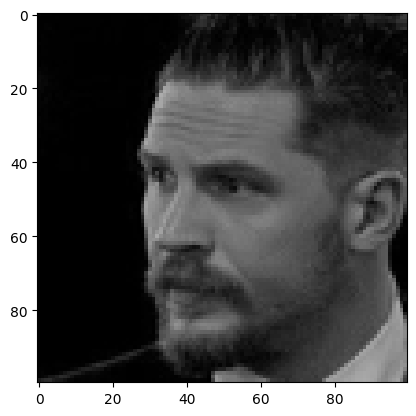

In [5]:
plt.imshow(train_x[0])

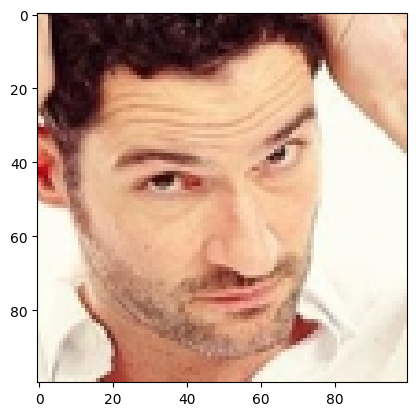

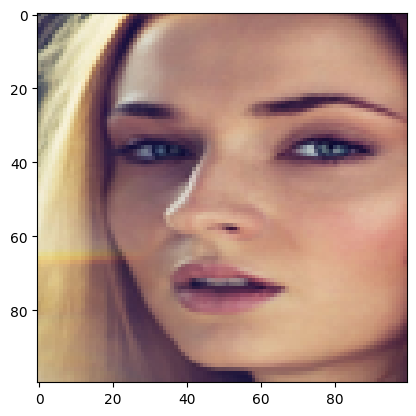

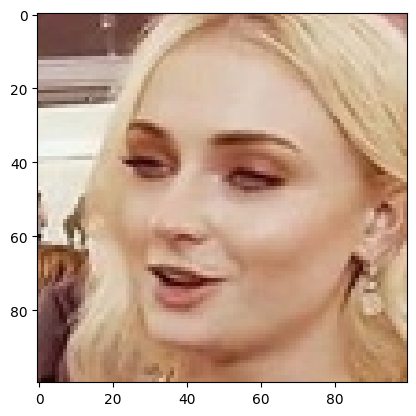

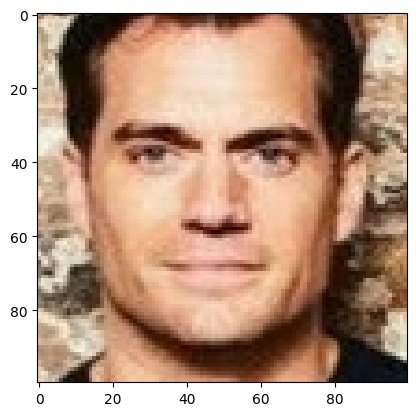

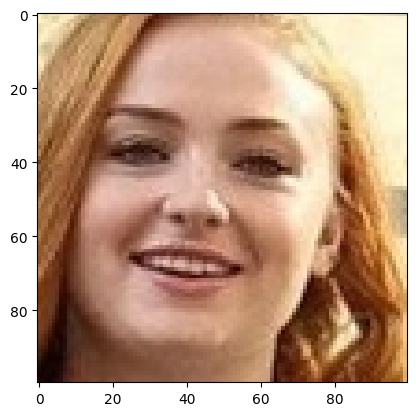

(3507, 100, 100, 3)

In [6]:

for i in range(0,5):
    plt.imshow(random.choice(images))
    plt.show()

train_x.shape
val_x.shape

In [7]:
train_x=train_x.reshape([14027,size])
val_x=val_x.reshape([3507,size])


### 3. Create Autoencoder architecture



In [8]:
## input layer
input_layer = Input(shape=(size))

## encoding architecture
encode_layer1 = Dense(1500, activation='relu')(input_layer)
encode_layer2 = Dense(1000, activation='relu')(encode_layer1)
encode_layer3 = Dense(500, activation='relu')(encode_layer2)

## latent view
latent_view   = Dense(10, activation='sigmoid')(encode_layer3)

## decoding architecture
decode_layer1 = Dense(500, activation='relu')(latent_view)
decode_layer2 = Dense(1000, activation='relu')(decode_layer1)
decode_layer3 = Dense(1500, activation='relu')(decode_layer2)

## output layer
output_layer  = Dense(size)(decode_layer3)

model = Model(input_layer, output_layer)

2023-10-25 10:47:17.818496: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-25 10:47:17.832715: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-25 10:47:17.832832: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Here is the summary of our autoencoder architecture.

In [9]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 30000)]           0         
                                                                 
 dense (Dense)               (None, 1500)              45001500  
                                                                 
 dense_1 (Dense)             (None, 1000)              1501000   
                                                                 
 dense_2 (Dense)             (None, 500)               500500    
                                                                 
 dense_3 (Dense)             (None, 10)                5010      
                                                                 
 dense_4 (Dense)             (None, 500)               5500      
                                                                 
 dense_5 (Dense)             (None, 1000)              501000

Next, we will train the model.

In [10]:
model.compile(optimizer='adam', loss='mse')

model.fit(train_x, train_x, epochs=1, batch_size=2048,validation_data=(val_x,val_x) )

2023-10-25 10:47:21.813057: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f9217ee2ae0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-10-25 10:47:21.813079: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2023-10-25 10:47:21.815841: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-10-25 10:47:21.916568: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8600
2023-10-25 10:47:21.974351: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


7/7 [==============================] - 4s 306ms/step - loss: 0.1917 - val_loss: 0.0999


Generate the predictions on validation data.

In [11]:
preds = model.predict(val_x)

110/110 [==============================] - 0s 3ms/step


Lets plot the original and predicted image

**Inputs: Actual Images**

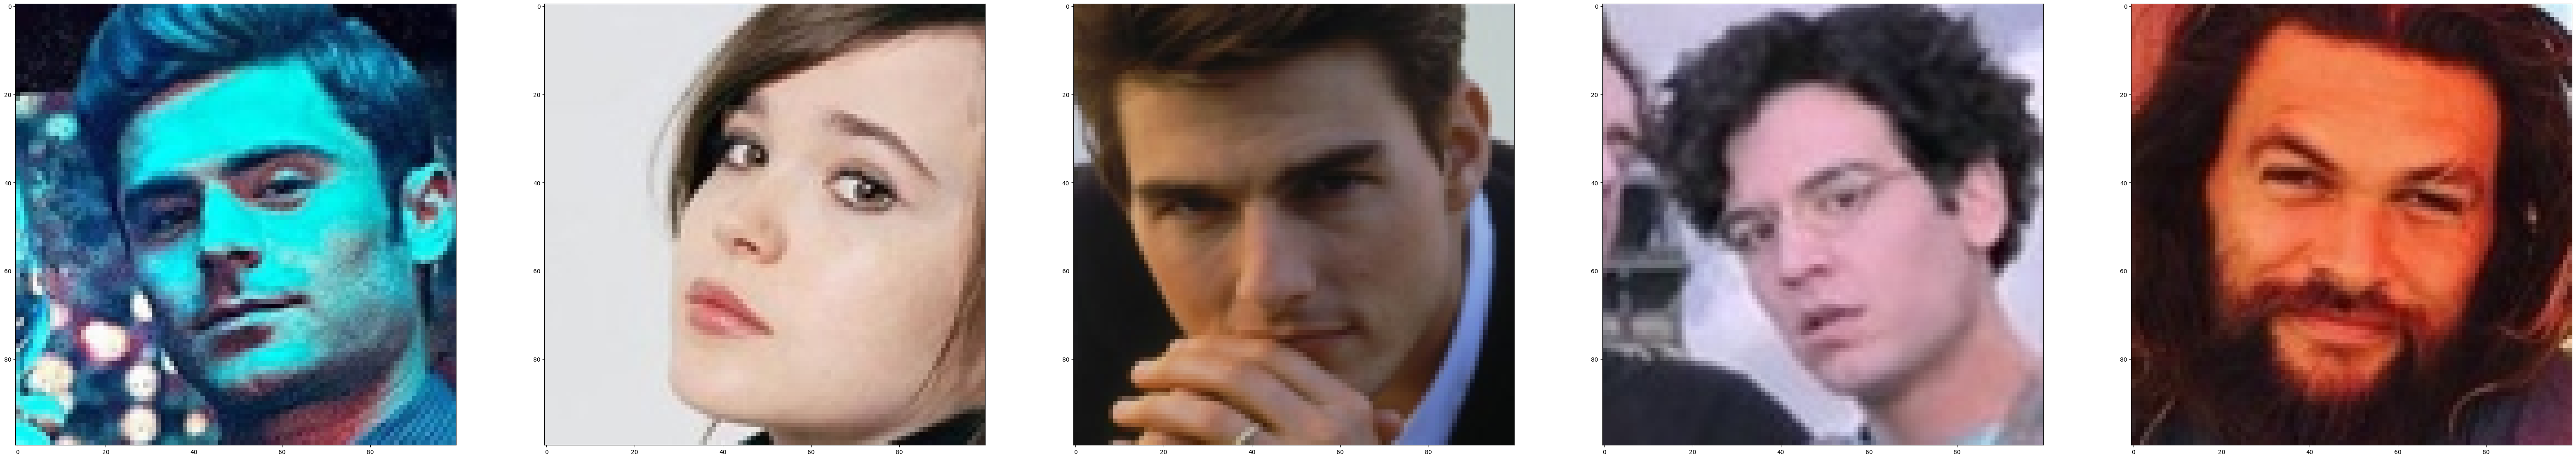

In [12]:
from PIL import Image
f, ax = plt.subplots(1,5)
f.set_size_inches(80, 40)
for i in range(5):
    ax[i].imshow(val_x[i].reshape(100, 100,3))
plt.show()

**Predicted : Autoencoder Output**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


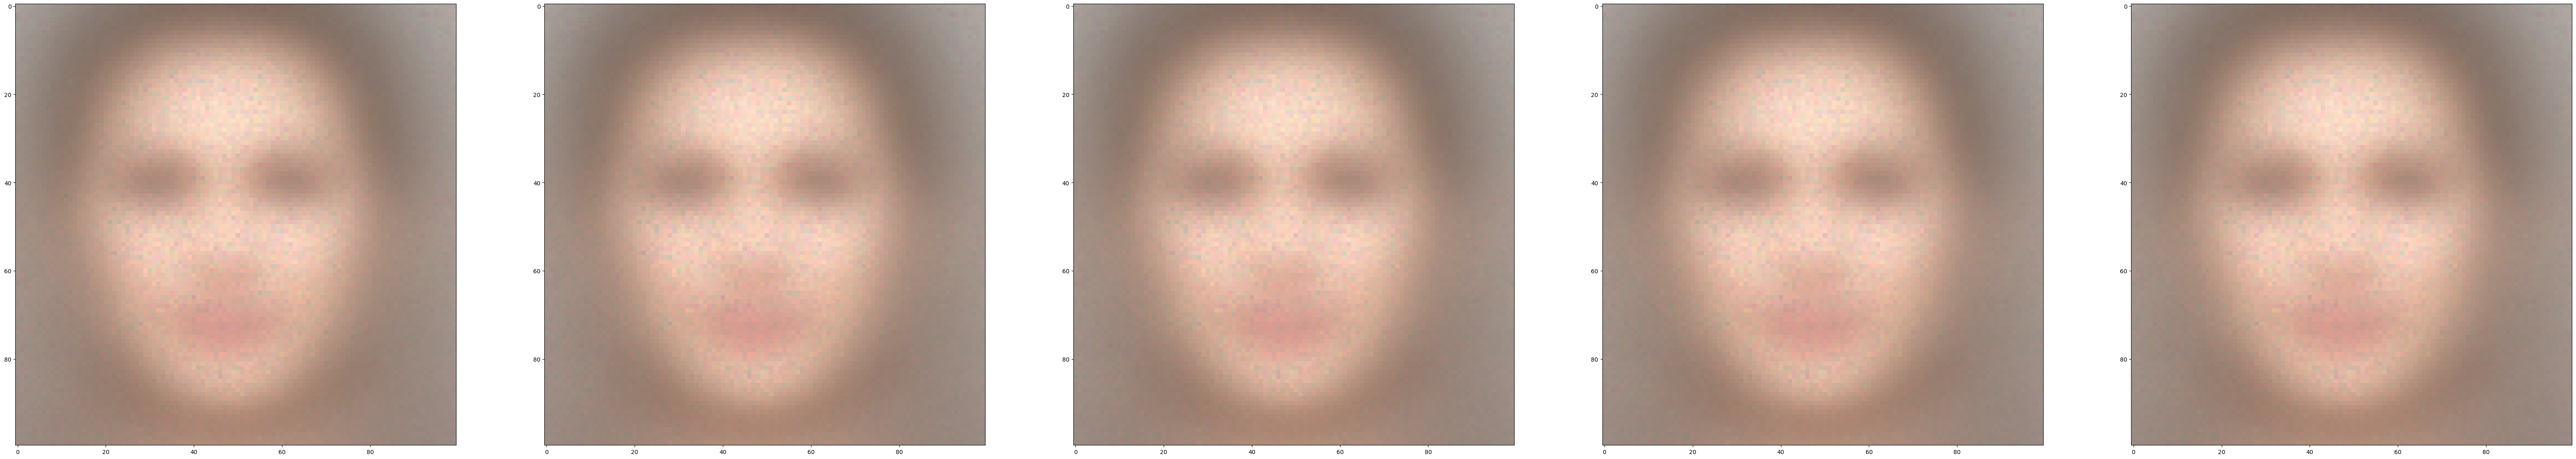

In [13]:
f, ax = plt.subplots(1,5)
f.set_size_inches(80, 40)
for i in range(5):
    ax[i].imshow(preds[i].reshape(100, 100,3))
plt.show()



## 2.2 UseCase 2 - Image Denoising




In [14]:
# Lets add sample noise - Salt and Pepper
noise = augmenters.SaltAndPepper(0.1)
seq_object = augmenters.Sequential([noise])
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='auto')

train_x_n = seq_object.augment_images(train_x * 255) / 255
val_x_n = seq_object.augment_images(val_x * 255) / 255

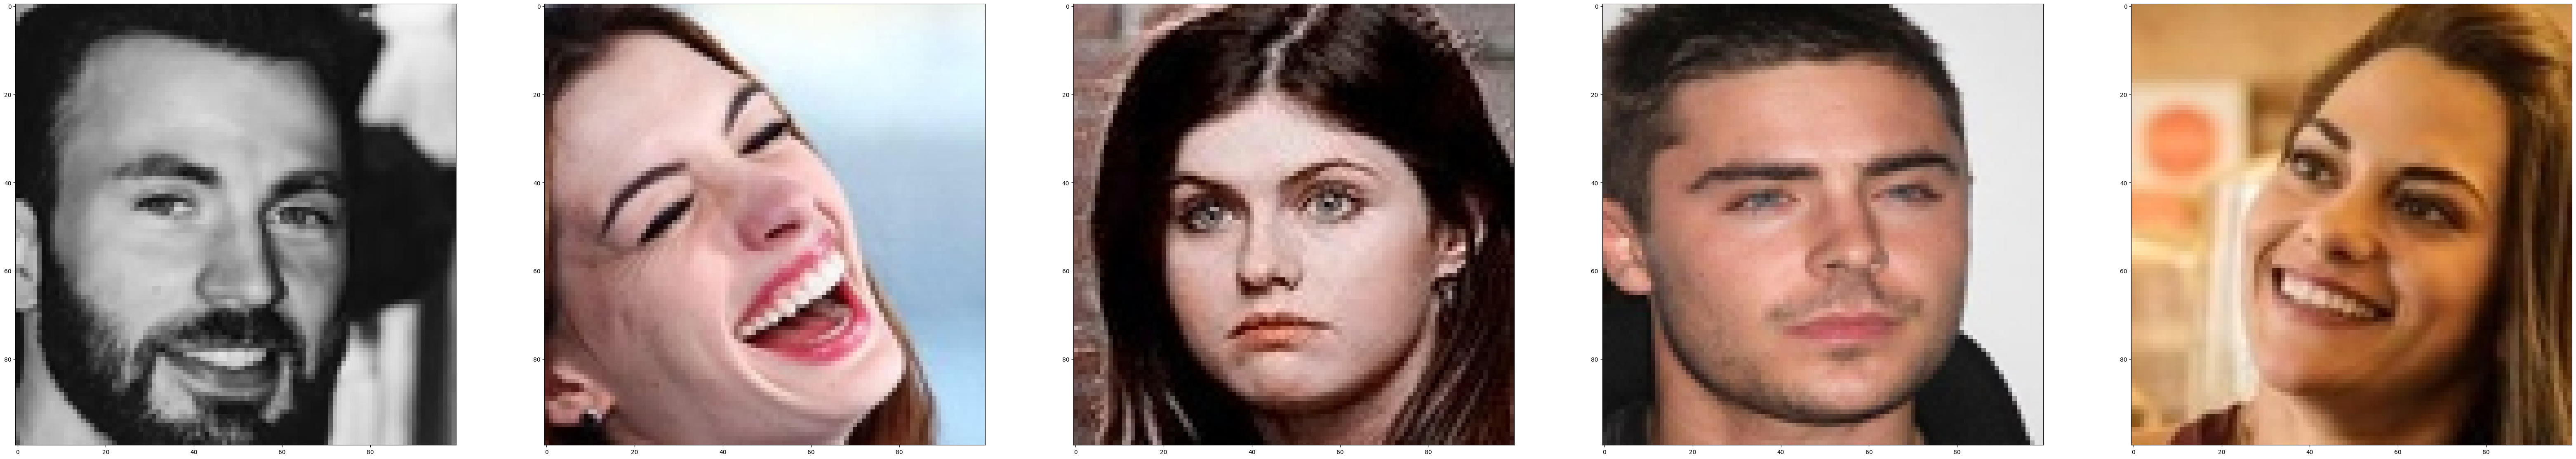

In [15]:
f, ax = plt.subplots(1,5)
f.set_size_inches(80, 40)
for i in range(5,10):
    ax[i-5].imshow(train_x[i].reshape(100, 100, 3))
plt.show()

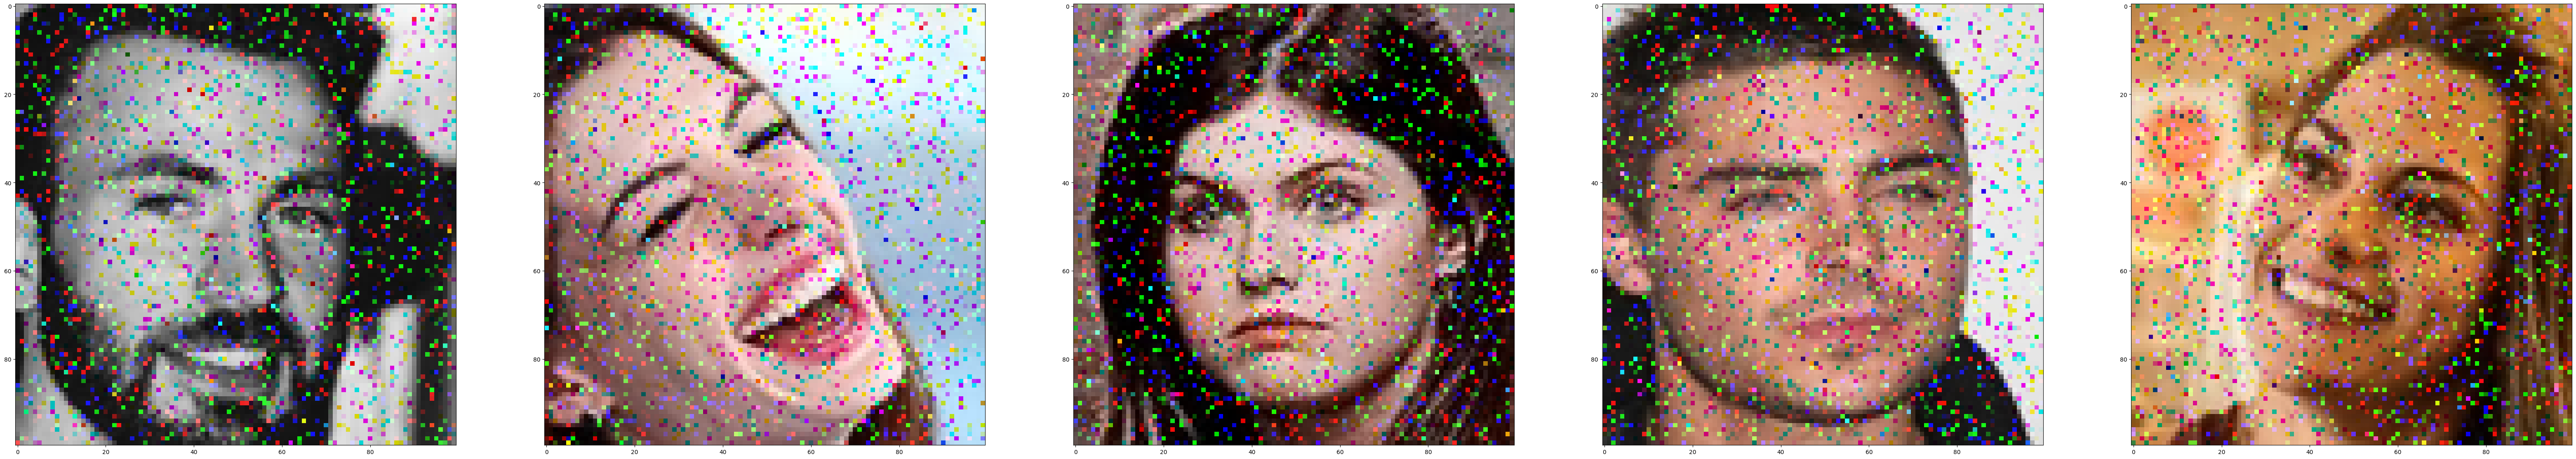

In [16]:
f, ax = plt.subplots(1,5)
f.set_size_inches(80, 40)
for i in range(5,10):
    ax[i-5].imshow(train_x_n[i].reshape(100, 100, 3))
plt.show()

In [17]:
train_x = train_x.reshape(-1, 100, 100, 3)

In [18]:
train_x_n = train_x_n.reshape(-1, 100, 100, 3)

In [19]:
val_x = val_x.reshape(-1, 100, 100, 3)

In [20]:
val_x_n = val_x_n.reshape(-1, 100, 100, 3)

In [21]:
# input layer
input_layer = Input(shape=(100, 100, 3))

# encoding architecture
encoded_layer1 = Conv2D(32, (3, 3), activation='relu', padding='same')(input_layer) #shape = (28, 28, 64)
encoded_layer1 = MaxPool2D( (2, 2), padding='same')(encoded_layer1) #Shape: (14, 14, 64)
encoded_layer2 = Conv2D(16, (3, 3), activation='relu', padding='same')(encoded_layer1) #Shape: (14, 14, 32)
encoded_layer2 = MaxPool2D( (2, 2), padding='same')(encoded_layer2) #Shape: (7, 7, 32)
encoded_layer3 = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded_layer2) #Shape: (7, 7, 16)
latent_view    = MaxPool2D( (2, 2), padding='same')(encoded_layer3) #Shape: (4, 4, 16)

# decoding architecture
decoded_layer1 = Conv2D(8, (3, 3), activation='relu', padding='same')(latent_view) #Shape: (4, 4, 16)
decoded_layer1 = UpSampling2D((2, 2))(decoded_layer1)  #Shape: (8, 8, 16) (due to upsampling with a 2x2 size)
decoded_layer2 = Conv2D(16, (3, 3), activation='relu', padding='same')(decoded_layer1) #Shape: (8, 8, 32)
decoded_layer2 = UpSampling2D((2, 2))(decoded_layer2)  #Shape: (16, 16, 32) (due to upsampling with a 2x2 size)
decoded_layer3 = Conv2D(32, (3, 3), activation='relu')(decoded_layer2) #Shape: (14, 14, 64) (due to the default padding='valid' in Conv2D)
decoded_layer3 = UpSampling2D((2, 2))(decoded_layer3) #Shape: (28, 28, 64) (due to upsampling with a 2x2 size)
output_layer   = Conv2D(3, (3, 3), padding='same')(decoded_layer3) #Shape: (28, 28, 1) (output channels represent the reconstructed image)

# compile the model
model_2 = Model(input_layer, output_layer)
model_2.compile(optimizer='adam', loss='mse')

Here is the model summary

In [22]:
model_2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 100, 100, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 50, 50, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 50, 50, 16)        4624      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 25, 25, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 25, 25, 8)         1160

Train the model with early stopping callback. Increase the number of epochs to a higher number for better results.

In [23]:
history = model_2.fit(train_x_n, train_x, epochs=15, batch_size=32, validation_data=(val_x_n, val_x))

Epoch 1/15
439/439 [==============================] - 9s 15ms/step - loss: 0.0228 - val_loss: 0.0112
Epoch 2/15
439/439 [==============================] - 5s 12ms/step - loss: 0.0097 - val_loss: 0.0086
Epoch 3/15
439/439 [==============================] - 5s 12ms/step - loss: 0.0083 - val_loss: 0.0080
Epoch 4/15
439/439 [==============================] - 5s 12ms/step - loss: 0.0078 - val_loss: 0.0075
Epoch 5/15
439/439 [==============================] - 5s 12ms/step - loss: 0.0073 - val_loss: 0.0071
Epoch 6/15
439/439 [==============================] - 5s 12ms/step - loss: 0.0070 - val_loss: 0.0069
Epoch 7/15
439/439 [==============================] - 5s 12ms/step - loss: 0.0067 - val_loss: 0.0065
Epoch 8/15
439/439 [==============================] - 5s 12ms/step - loss: 0.0065 - val_loss: 0.0063
Epoch 9/15
439/439 [==============================] - 5s 12ms/step - loss: 0.0063 - val_loss: 0.0063
Epoch 10/15
439/439 [==============================] - 5s 12ms/step - loss: 0.0061 - val_lo

Lets obtain the predictions of the model

1/1 [==============================] - 0s 193ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


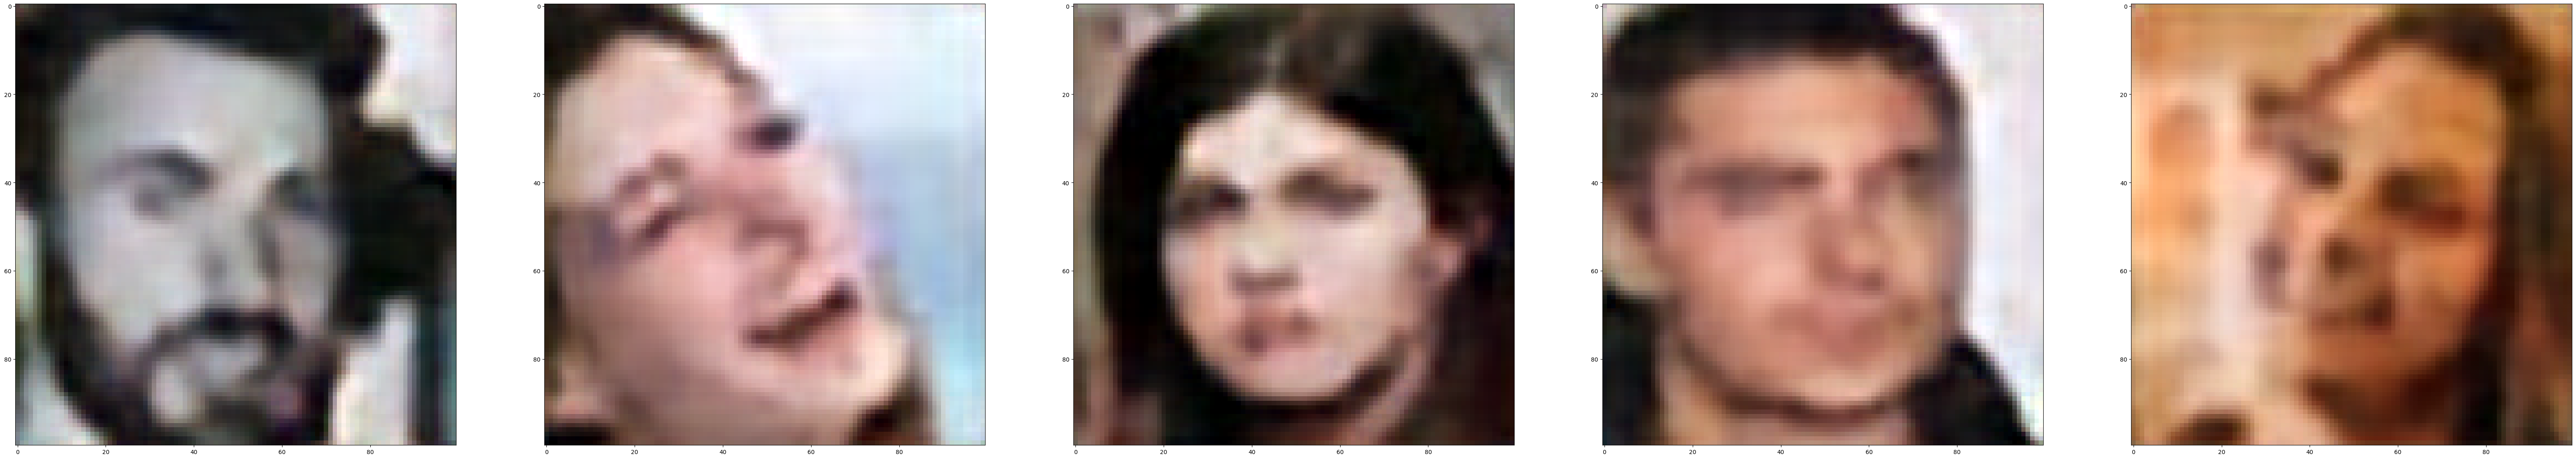

In [24]:
preds = model_2.predict(train_x_n[:10])
f, ax = plt.subplots(1,5)
f.set_size_inches(80, 40)
for i in range(5,10):
    ax[i-5].imshow(preds[i].reshape(100, 100, 3))
plt.show()